In [1]:
import torch
import torch.nn as nn

from torch import optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torch.utils.data

import pandas as pd

from utils.tokenMaker import Lang
from utils.tool import padding, flatMutileLength, fixString
from model.BigModel import SubImgToSeq, SubVideoToSeq
from dataset.readVideo import DramaDataset
useCuda = True
device = torch.device("cuda" if useCuda else "cpu")

In [67]:
DataDir="/home/ball/Videos/Broke"
datasets = DramaDataset(basedir=DataDir,
                        maxFrame=1,
                        timeOffset=0.2,
                        startSeries=1,
                        maxSeries=5,
                        pairTime=1,
                        useBmp=False,
                        randomStart=False)
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
len(datasets)

Total Drama: 113


42690

In [4]:
import random
def getSample(size):
    imgs = []
    pres = []
    nexs = []
    for i in range(size):
        pre, nex, img = random.choice(datasets)
        imgs.append(img)
        pres.append(pre)
        nexs.append(nex)
    return pres, nexs, imgs

In [5]:
def predit(model, lang, imgs, subtitle, max_length=50):
    ans = []
    probs = []
    inputImgs = imgs.unsqueeze(0).to(device)
    subtitle = torch.LongTensor(lang.sentenceToVector(subtitle, sos=False, eos=False)).unsqueeze(0).to(device)
    inputs = torch.LongTensor([[lang["SOS"]]]).long().to(device)
    
    hidden = None
    
    cxt = model.makeContext(inputImgs, subtitle)
    for i in range(max_length):
        outputs, hidden = model.decode(inputs, cxt, hidden)
        prob, outputs = outputs.topk(1)
        probs.append(prob.item())

        if(outputs.item() == lang["EOS"]):
            break
        ans.append(outputs.item())

        inputs = outputs.squeeze(1).detach()
    return lang.vectorToSentence(ans), probs

def mutilePredit(pres, nexs, imgs):
    makes = []
    for pre, nex, img in zip(pres, nexs, imgs):
        mk = predit(model, lang, transform(img[0]).unsqueeze(0), pre)
        makes.append(mk[0])
    return makes

def toBatchFirst(outputs):
    nep = len(outputs)
    nbatch = len(outputs[0])
    bFirst = []
    for b in range(nbatch):
        bdatas = []
        for e in range(nep):
            bdatas.append(outputs[e][b])
        bFirst.append(bdatas)
    return bFirst

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
toPIL = transforms.ToPILImage()

def showImgs(imgs, preSubs, targets, labels):
    col=1
    plt.figure(figsize=(20,50))
    for i in range(len(imgs)):
        plt.subplot(len(imgs)/col+1,col,i+1)
        plt.axis('off')
        plt.imshow(imgs[i])
        plt.title("Pre: {}\nNext: {}\nPredit: {}".format(preSubs[i], targets[i], labels[i]), fontsize=20)
    plt.show()
def showVar(data):
    x = range(0, data.size(-1))
    plt.bar(x, data.data.cpu())
    plt.show()
def showValue(data):
    x = range(0, len(data))
    plt.plot(x, data)
    plt.show()

In [230]:
import pickle
import os
ModelDir = "ImgSub2Sub/models/BK_CH_FIX_200"
# ModelDir = "ImgSub2Sub/models.old/bken_fix_150"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
model = torch.load(os.path.join(ModelDir, "SubImgModel.40.pth")).to(device).eval()

Load lang model: ImgSub2Sub/models/BK_CH_FIX_200. Word size: 3801


In [207]:
pres, nexs, imgs = getSample(5)

In [232]:
ppres, pnexs, pimgs = pres, nexs, imgs
ppres = [ppres[0]]*len(ppres)
# pimgs = [pimgs[0]]*len(pimgs)
makes = mutilePredit(ppres, pnexs, pimgs)

In [229]:
ppres

['我剛才說服了安吉洛租后辦公室給我們', '他身邊沒有好友告訴他', '說是點了白面不加配料的', '我們只知道', '可這是我想要的']

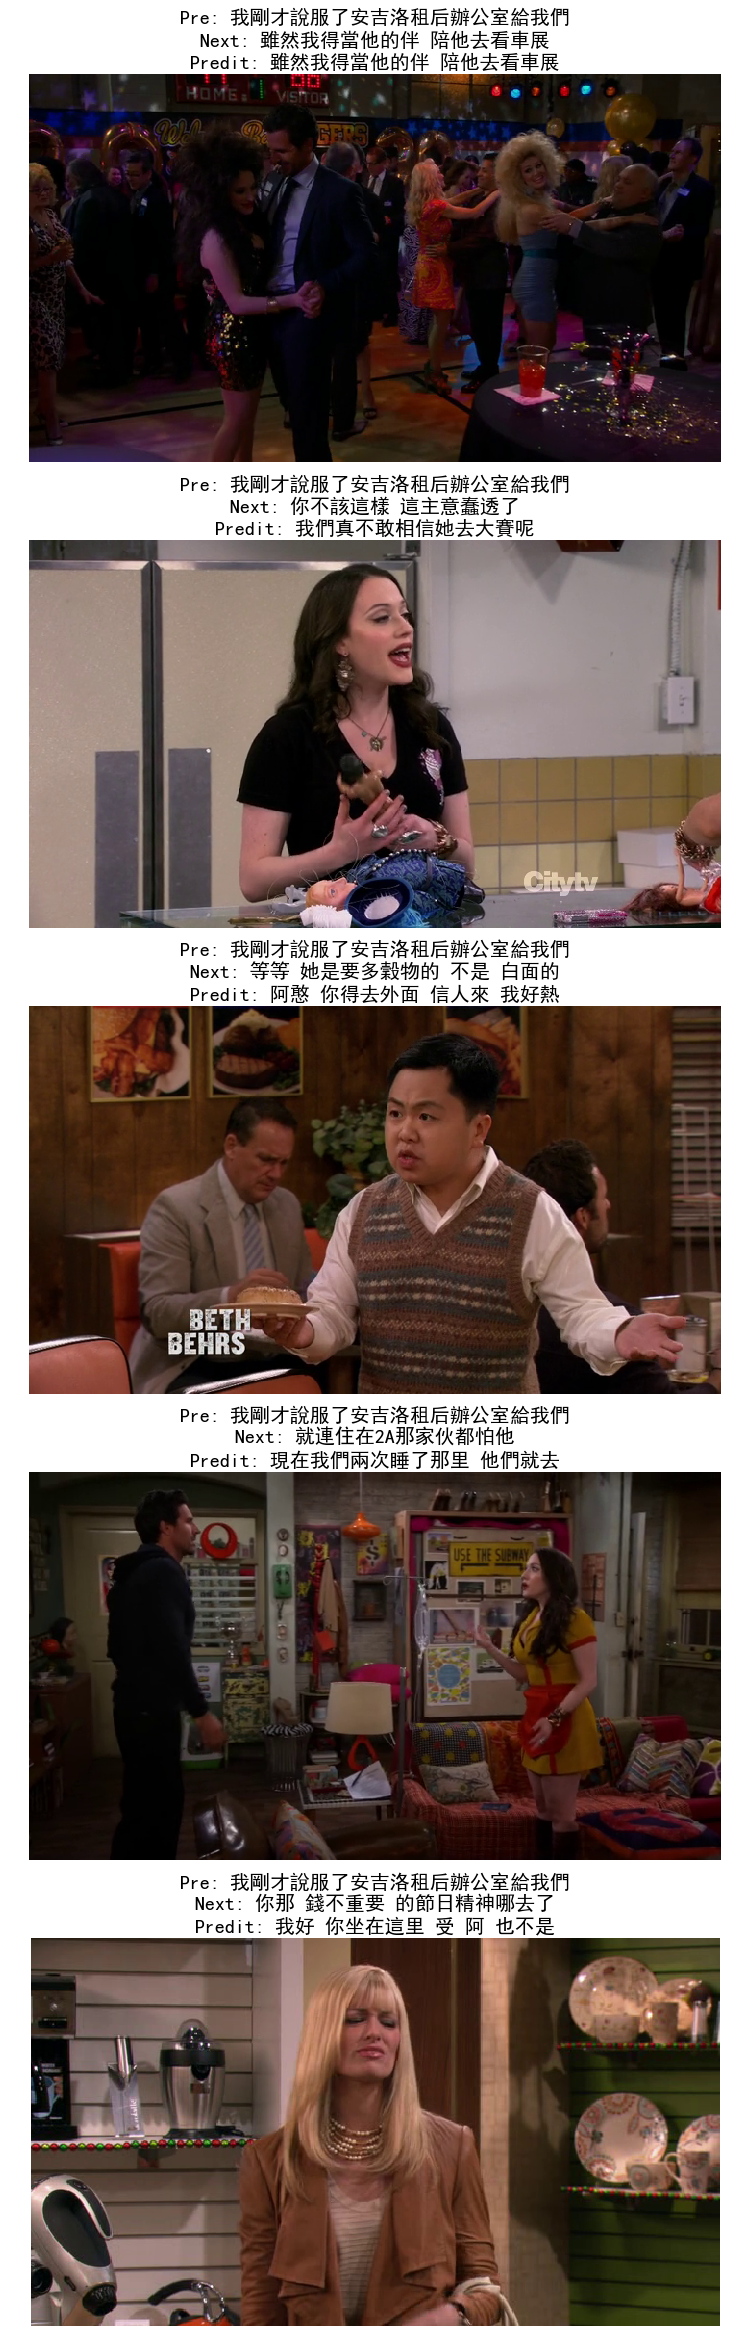

In [233]:
showImgs([ims[0] for ims in pimgs], ppres, pnexs, makes)

In [14]:
import pandas as pd
result = pd.DataFrame([], columns=["pre", "next", "make"])
for _ in range(10):
    pres, nexs, imgs = getSample(64)
    makes = mutilePredit(pres, nexs, imgs)
    parts = pd.DataFrame([], columns=["pre", "next"])
    parts["pre"] = pres
    parts["next"] = nexs
    parts["make"] = makes
    result = result.append(parts,ignore_index=True)

In [37]:
def getEncoder(modal, sub):
    subVar =  torch.LongTensor(lang.sentenceToVector(sub, sos=False, eos=False)).to(device).unsqueeze(0)
    return modal.subRnn(subVar)[0][:,-1,:]
cos = nn.CosineSimilarity(dim=1)

In [101]:
pres, nexs, imgs = getSample(64)

In [107]:
epcoss = []
outputs = []
result = pd.DataFrame([], columns=["pre", "next", "make"])
for i in range(1, 41):
    model = torch.load(os.path.join(ModelDir, "SubImgModel.{}.pth".format(i))).eval()
    makes = mutilePredit(pres, nexs, imgs)
    tars = torch.cat([getEncoder(model, nex) for nex in nexs], dim=0)
    preds = torch.cat([getEncoder(model, pred) for pred in makes], dim=0)
    cs = cos(tars, preds)
    epcoss.append(cs.mean().item())
    outputs.append(makes)
    
    parts = pd.DataFrame([], columns=["pre", "next"])
    parts["pre"] = pres
    parts["next"] = nexs
    parts["make"] = makes
    parts["epoch"] = i
    result = result.append(parts,ignore_index=True)
    print("Mean: {:.4f}, Max: {:.4f}, Min: {:.4f}".format(cs.mean().item(),
                                             cs.max().item(),
                                             cs.min().item()))
bfOutputs = toBatchFirst(outputs)

Mean: 0.0342, Max: 0.2396, Min: -0.1804
Mean: 0.0202, Max: 0.3111, Min: -0.2015
Mean: 0.0187, Max: 0.2278, Min: -0.1332
Mean: 0.0345, Max: 0.3916, Min: -0.1708
Mean: 0.0333, Max: 0.3531, Min: -0.1864
Mean: 0.0203, Max: 0.2077, Min: -0.1658
Mean: 0.0184, Max: 0.2033, Min: -0.2024
Mean: 0.0166, Max: 0.2333, Min: -0.2084
Mean: 0.0353, Max: 0.3777, Min: -0.1468
Mean: -0.0048, Max: 0.2613, Min: -0.1515
Mean: 0.0280, Max: 0.2849, Min: -0.1736
Mean: 0.0259, Max: 0.4975, Min: -0.1695
Mean: 0.0089, Max: 0.2259, Min: -0.1942
Mean: 0.0270, Max: 0.5477, Min: -0.1723
Mean: 0.0305, Max: 0.4291, Min: -0.1564
Mean: 0.0169, Max: 0.2671, Min: -0.1016
Mean: 0.0181, Max: 0.1998, Min: -0.2152
Mean: 0.0169, Max: 0.3046, Min: -0.1283
Mean: 0.0323, Max: 0.3176, Min: -0.1153
Mean: 0.0057, Max: 0.1594, Min: -0.1375
Mean: 0.0169, Max: 0.2709, Min: -0.0964
Mean: 0.0181, Max: 0.3809, Min: -0.1696
Mean: 0.0369, Max: 0.2251, Min: -0.1249
Mean: 0.0189, Max: 0.2335, Min: -0.1487
Mean: 0.0296, Max: 0.4649, Min: -0.1781

In [108]:
result.to_json("others/result_bk_ch_rd_outs.json")

In [87]:
coss = []
for makes in outputs:
    tars = torch.cat([getEncoder(model, nex) for nex in nexs], dim=0)
    preds = torch.cat([getEncoder(model, pred) for pred in makes], dim=0)
    cs = cos(tars, preds)
    coss.append(cs.mean().item())
    print("Mean: {:.4f}, Max: {:.4f}, Min: {:.4f}, Equal: {}".format(cs.mean().item(),
                                                         cs.max().item(),
                                                         cs.min().item(),
                                                         (cs>=0.9).float().sum().item()))

Mean: 0.0268, Max: 0.3567, Min: -0.1333, Equal: 0.0
Mean: 0.0448, Max: 0.8547, Min: -0.1798, Equal: 0.0
Mean: 0.0672, Max: 0.8064, Min: -0.1214, Equal: 0.0
Mean: 0.0667, Max: 0.8009, Min: -0.0772, Equal: 0.0
Mean: 0.0950, Max: 0.6751, Min: -0.0853, Equal: 0.0
Mean: 0.0791, Max: 0.8399, Min: -0.1110, Equal: 0.0
Mean: 0.0830, Max: 0.8399, Min: -0.1478, Equal: 0.0
Mean: 0.0970, Max: 0.9650, Min: -0.1468, Equal: 1.0
Mean: 0.0717, Max: 0.5815, Min: -0.1634, Equal: 0.0
Mean: 0.0811, Max: 0.8391, Min: -0.0951, Equal: 0.0
Mean: 0.1365, Max: 0.9660, Min: -0.1636, Equal: 2.0
Mean: 0.0793, Max: 0.8391, Min: -0.1612, Equal: 0.0
Mean: 0.0875, Max: 0.8391, Min: -0.1179, Equal: 0.0
Mean: 0.0892, Max: 0.8391, Min: -0.1087, Equal: 0.0
Mean: 0.0829, Max: 0.8391, Min: -0.1473, Equal: 0.0
Mean: 0.1461, Max: 1.0000, Min: -0.1064, Equal: 4.0
Mean: 0.1312, Max: 1.0000, Min: -0.0985, Equal: 2.0
Mean: 0.1280, Max: 1.0000, Min: -0.1226, Equal: 2.0
Mean: 0.2027, Max: 1.0000, Min: -0.1100, Equal: 7.0
Mean: 0.0871

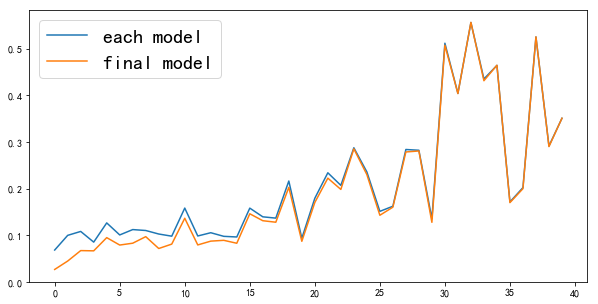

In [88]:
x = range(0, len(coss))
plt.figure(figsize=(10,5))
plt.plot(x, epcoss, label="each model")
plt.plot(x, coss, label="final model")

plt.legend(fontsize=20)
plt.show()

In [ ]:
i = 25
print("Pre: {}".format(pres[i]))
print("Next: {}\n".format(nexs[i]))
print("\n".join(bfOutputs[i]))
plt.axis('off')
plt.imshow(imgs[i][0])
plt.show()

In [91]:
result[result["epoch"]==40]

,epoch,make,next,pre
2496,40.0,都是有 種 的男的,都是有 種 的女人,印證了一個理論 洛城的女人
2497,40.0,大家把這裏放出來的60大洋雞蛋買給大吧,就是讓這酒吧蓬蓽生輝的那個厄爾,早鳥樂隊那個
2498,40.0,早安 你好玩兒,你奶奶的家很豪華嘛,你好啊 卡洛琳
2499,40.0,接下來的24小時,接下來的24小時,那男的絕對不可能還活著
2500,40.0,我們一起抽一管大麻 然後自殺,我們一起抽一管大麻 然后自殺,我們有一個大麻自殺協議
2501,40.0,或許我們可以有個原因 有個小作弊日中的 不過小心大覺得,或許我們可以有個小作弊日,我還不能就這些詞開黃腔
2502,40.0,來讓你在威廉斯堡蛋糕店裏的人,拒絕服務 LGBTQ 族群的人,有倆小姑娘開小蛋糕店
2503,40.0,我沒有說你以為你今天的女人,麥克斯不是厄爾的女朋友,不是不是不是
2504,40.0,他在和她親親 他也不在地板,他在這里可是知名大人物,我可以介紹你跟我一個老朋友認識
2505,40.0,好吧 我有個派對,這是您的派,她也相信十四號桌是四十號桌
